## Raw MxN Matrix

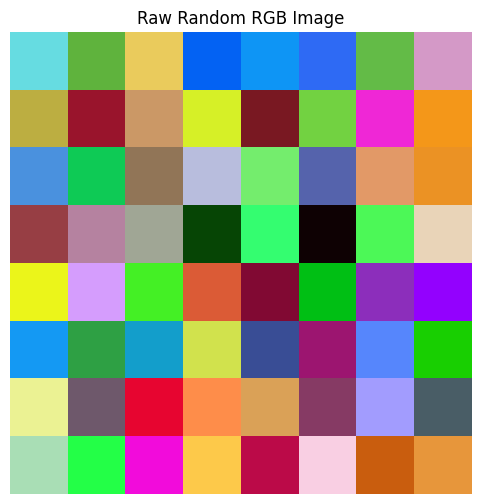

In [226]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Generate a random matrix M × N of values 0-255
M, N = 8, 8  # Define dimensions
raw_image = np.random.randint(0, 256, size=(M, N, 3), dtype=np.uint8)

# Visualize the raw random image
plt.figure(figsize=(6, 6))
plt.imshow(raw_image)
plt.title('Raw Random RGB Image')
plt.axis('off')
plt.show()

## Display pixel values

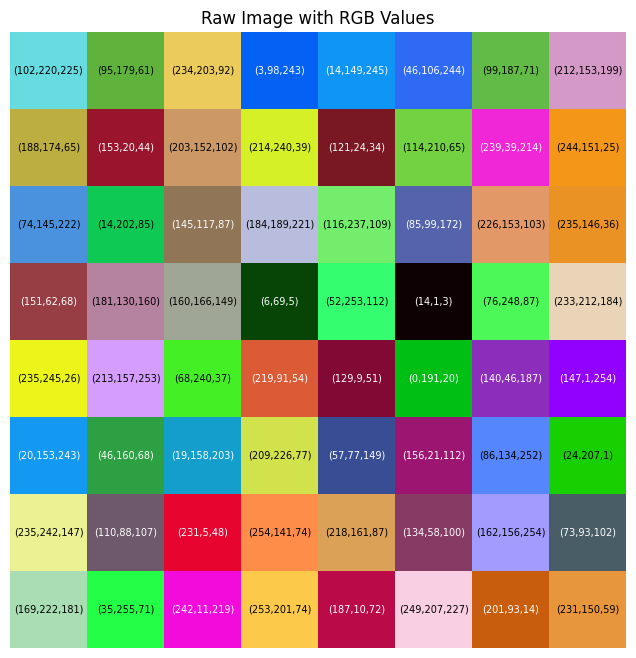

In [227]:
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.title('Raw Image with RGB Values')
for i in range(M):
    for j in range(N):
        r, g, b = raw_image[i, j]
        text = f"({r},{g},{b})"
        brightness = (r*0.299 + g*0.587 + b*0.114) / 255
        text_color = 'black' if brightness > 0.5 else 'white'
        plt.text(j, i, text, ha='center', va='center', color=text_color, fontsize=7)
plt.axis('off')
plt.show()

## Generate a correct form of Bayer filter (RGGB pattern)

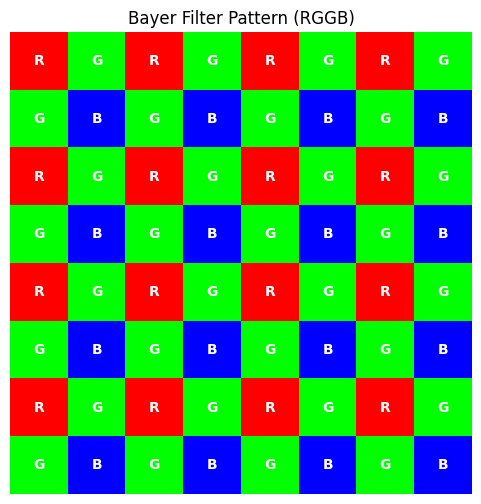

In [228]:
bayer = np.zeros((M, N), dtype=str)
bayer_visual = np.zeros((M, N, 3), dtype=np.uint8)

for i in range(M):
    for j in range(N):
        if i % 2 == 0 and j % 2 == 0:
            bayer[i, j] = 'R'  # Red
            bayer_visual[i, j] = [255, 0, 0]  # Red in RGB
        elif i % 2 == 0 and j % 2 == 1:
            bayer[i, j] = 'G'  # Green
            bayer_visual[i, j] = [0, 255, 0]  # Green in RGB
        elif i % 2 == 1 and j % 2 == 0:
            bayer[i, j] = 'G'  # Green
            bayer_visual[i, j] = [0, 255, 0]  # Green in RGB
        else:
            bayer[i, j] = 'B'  # Blue
            bayer_visual[i, j] = [0, 0, 255]  # Blue in RGB

# Visualize the Bayer pattern
plt.figure(figsize=(6, 6))
plt.imshow(bayer_visual)
plt.title('Bayer Filter Pattern (RGGB)')
for i in range(M):
    for j in range(N):
        plt.text(j, i, bayer[i, j], ha='center', va='center', color='white', fontweight='bold')
plt.axis('off')
plt.show()

## Map the correct values (simulate camera sensor readings)

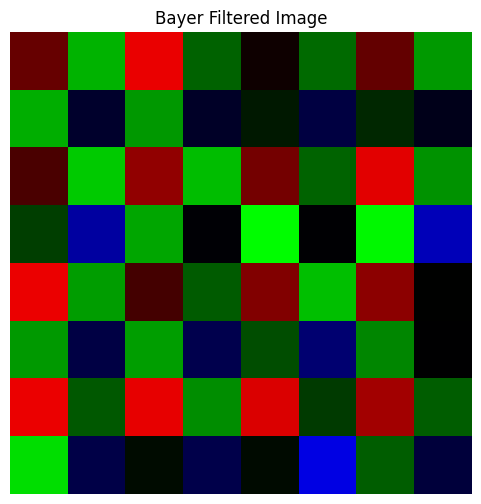

In [229]:
bayer_image = np.zeros((M, N, 3), dtype=np.uint8)
for i in range(M):
    for j in range(N):
        if bayer[i, j] == 'R':
            bayer_image[i, j, 0] = raw_image[i, j, 0]  # Only retain red channel
        elif bayer[i, j] == 'G':
            bayer_image[i, j, 1] = raw_image[i, j, 1]  # Only retain green channel
        else:  # 'B'
            bayer_image[i, j, 2] = raw_image[i, j, 2]  # Only retain blue channel

plt.figure(figsize=(6, 6))
plt.imshow(bayer_image)
plt.title('Bayer Filtered Image')
plt.axis('off')
plt.show()

## Interpolate the missing values (demosaicing)

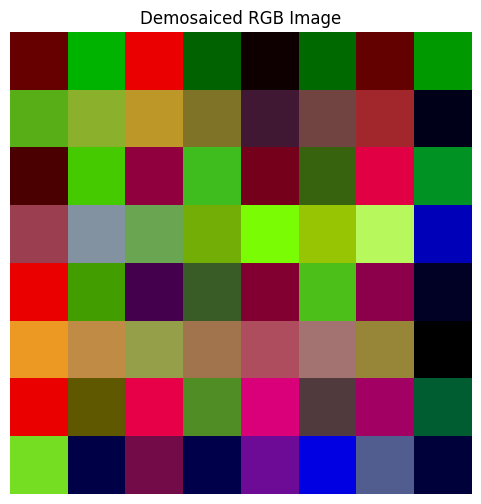

In [230]:
rgb = bayer_image.astype(float)
height, width = rgb.shape[:2]
    
# Interpolate Green
for i in range(0, height, 2):
    for j in range(0, width, 2):
        if i+1 < height and j+1 < width:
            # Green at blue positions
            rgb[i+1, j+1, 1] = (rgb[i, j+1, 1] + rgb[i+1, j, 1] + 
                               rgb[i+2, j+1, 1] + rgb[i+1, j+2, 1]) / 4 if i+2 < height and j+2 < width else rgb[i+1, j+1, 1]

# Interpolate Red and Blue
for i in range(height):
    for j in range(width):
        if bayer[i, j] == 'G':
            # At green pixels, interpolate red and blue
            rgb[i, j, 0] = (rgb[max(0, i-1), j, 0] + rgb[min(height-1, i+1), j, 0]) / 2  # Red
            rgb[i, j, 2] = (rgb[i, max(0, j-1), 2] + rgb[i, min(width-1, j+1), 2]) / 2  # Blue
        elif bayer[i, j] == 'R':
            # At red pixels, interpolate blue
            if i > 0 and i < height-1 and j > 0 and j < width-1:
                # Use diagonal blue pixels for interpolation
                rgb[i, j, 2] = (rgb[i-1, j-1, 2] + rgb[i-1, j+1, 2] + 
                               rgb[i+1, j-1, 2] + rgb[i+1, j+1, 2]) / 4
        elif bayer[i, j] == 'B':
            # At blue pixels, interpolate red
            if i > 0 and i < height-1 and j > 0 and j < width-1:
                # Use diagonal red pixels for interpolation
                rgb[i, j, 0] = (rgb[i-1, j-1, 0] + rgb[i-1, j+1, 0] + 
                               rgb[i+1, j-1, 0] + rgb[i+1, j+1, 0]) / 4
    
demosaiced_image = rgb.clip(0, 255).astype(np.uint8)

plt.figure(figsize=(6, 6))
plt.imshow(demosaiced_image)
plt.title('Demosaiced RGB Image')
plt.axis('off')
plt.show()

## Transform to HSV color space

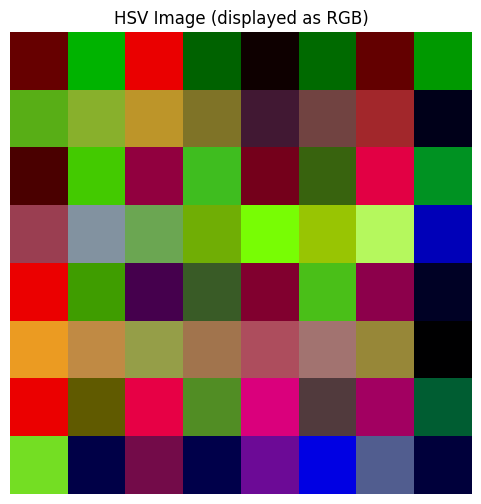

In [231]:
hsv_image = cv2.cvtColor(demosaiced_image, cv2.COLOR_RGB2HSV)

# For proper visualization (convert back to RGB)
hsv_display = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(hsv_display)
plt.title('HSV Image (displayed as RGB)')
plt.axis('off')
plt.show()

## Compare all images side by side

Sample Data Comparison:
--------------------------------------------------
Position (0,0):
  Raw RGB: [102 220 225]
  Bayer Filter: R
  Filtered: [102   0   0]
  Demosaiced: [102   0   0]
  HSV: [  0 255 102]
------------------------------
Position (0,1):
  Raw RGB: [ 95 179  61]
  Bayer Filter: G
  Filtered: [  0 179   0]
  Demosaiced: [  0 179   0]
  HSV: [ 60 255 179]
------------------------------
Position (0,2):
  Raw RGB: [234 203  92]
  Bayer Filter: R
  Filtered: [234   0   0]
  Demosaiced: [234   0   0]
  HSV: [  0 255 234]
------------------------------
Position (0,3):
  Raw RGB: [  3  98 243]
  Bayer Filter: G
  Filtered: [ 0 98  0]
  Demosaiced: [ 0 98  0]
  HSV: [ 60 255  98]
------------------------------
Position (0,4):
  Raw RGB: [ 14 149 245]
  Bayer Filter: R
  Filtered: [14  0  0]
  Demosaiced: [14  0  0]
  HSV: [  0 255  14]
------------------------------
Position (0,5):
  Raw RGB: [ 46 106 244]
  Bayer Filter: G
  Filtered: [  0 106   0]
  Demosaiced: [  0 106   0]

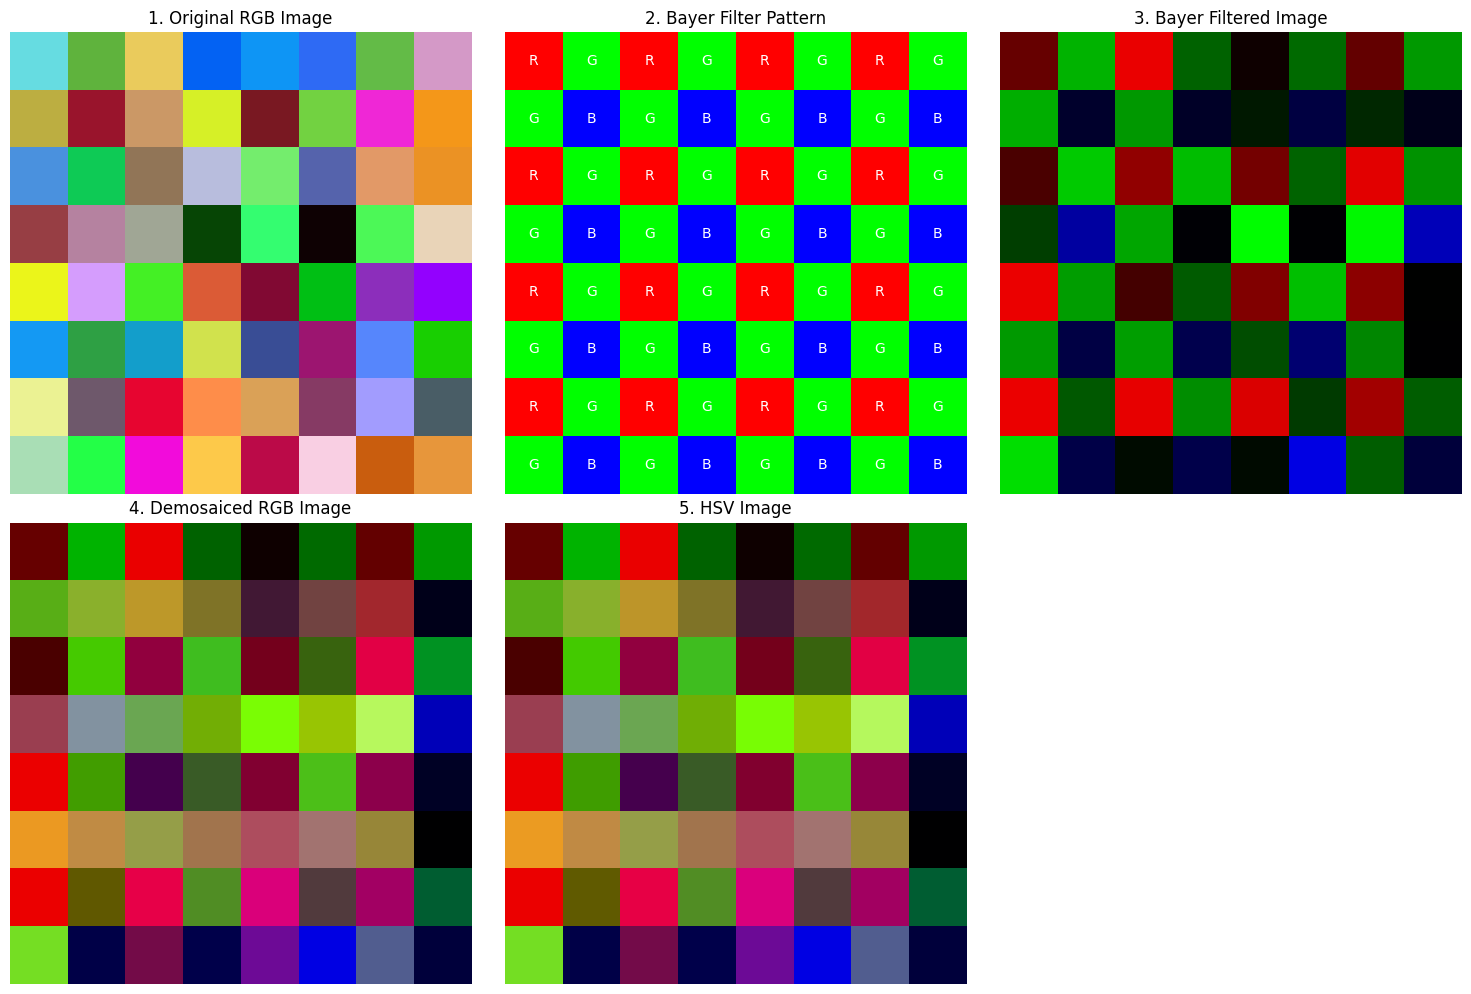

In [232]:
plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.imshow(raw_image)
plt.title('1. Original RGB Image')
plt.axis('off')

plt.subplot(232)
plt.imshow(bayer_visual)
for i in range(M):
    for j in range(N):
        plt.text(j, i, bayer[i, j], ha='center', va='center', color='white')
plt.title('2. Bayer Filter Pattern')
plt.axis('off')

plt.subplot(233)
plt.imshow(bayer_image)
plt.title('3. Bayer Filtered Image')
plt.axis('off')

plt.subplot(234)
plt.imshow(demosaiced_image)
plt.title('4. Demosaiced RGB Image')
plt.axis('off')

plt.subplot(235)
plt.imshow(hsv_display)
plt.title('5. HSV Image')
plt.axis('off')

# Sample data for comparison
print("Sample Data Comparison:")
print("-" * 50)
for i in range(M):
    for j in range(N):
        print(f"Position ({i},{j}):")
        print(f"  Raw RGB: {raw_image[i,j]}")
        print(f"  Bayer Filter: {bayer[i,j]}")
        print(f"  Filtered: {bayer_image[i,j]}")
        print(f"  Demosaiced: {demosaiced_image[i,j]}")
        print(f"  HSV: {hsv_image[i,j]}")
        print("-" * 30)

plt.tight_layout()
plt.show()

(-0.5, 7.5, 7.5, -0.5)

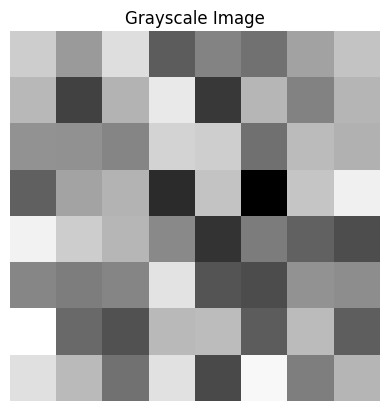

In [233]:
gray_image = cv2.cvtColor(raw_image, cv2.COLOR_RGB2GRAY)

plt.imshow(gray_image, cmap='gray')  # 'gray' colormap is important for proper visualization
plt.title('Grayscale Image')
plt.axis('off')

(-0.5, 7.5, 7.5, -0.5)

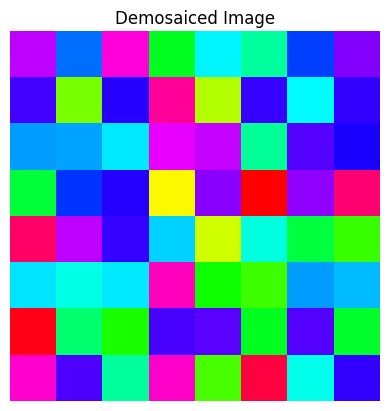

In [234]:
demosaiced_image = cv2.demosaicing(gray_image, cv2.COLOR_BAYER_BG2RGB)

plt.imshow(gray_image, cmap="hsv")
plt.title('Demosaiced Image')
plt.axis('off')